# Factors that affect life expectancy

I will be using the Life Expectancy data from WHO, and will be going over data cleaning, inspection, PCA, and plotting geographic data with plotly.

As the comments on this data suggest, there are a lot of issues with the data collection methods and the resulting observations, but it is still usable to gain valuable insights. 

Let's go ahead and dive into the inspection and cleaning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

import plotly.express as px

In [2]:
import pandas as pd
le_df = pd.read_csv("../input/life-expectancy-who/Life Expectancy Data.csv")

In [3]:
le_df.info()

#output cut out some of the columns. hacked it.
le_df[:5].T.head(22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

,0,1,2,3,4
Country,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Year,2015,2014,2013,2012,2011
Status,Developing,Developing,Developing,Developing,Developing
Life expectancy,65,59.9,59.9,59.5,59.2
Adult Mortality,263,271,268,272,275
infant deaths,62,64,66,69,71
Alcohol,0.01,0.01,0.01,0.01,0.01
percentage expenditure,71.2796,73.5236,73.2192,78.1842,7.09711
Hepatitis B,65,62,64,67,68
Measles,1154,492,430,2787,3013


In [4]:
# I'm going to adjust the columns names and remove extra spacing for ease of use
le_df.rename(columns = lambda x: x.strip().replace(' ', '_').lower(), inplace=True)

# one column doesn't match our underscoring convention or the Kaggle description. fixing.
le_df.rename(columns = {'thinness__1-19_years':'thinness_10-19_years'}, inplace=True)

print((f'Number of columns: {len(le_df.columns)}'))
le_df.columns
# that's better

Number of columns: 22


Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_10-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

**Lets inspect the data for nans, any outliers, and fix some issues with the data collection**

In [5]:
# checking for nans
le_df.isnull().sum()

country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under-five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hiv/aids                             0
gdp                                448
population                         652
thinness_10-19_years                34
thinness_5-9_years                  34
income_composition_of_resources    167
schooling                          163
dtype: int64

In [6]:
# will fill nans multiple ways to see what approach is best
le_df2 = le_df.copy() # will fill by mean
le_df3 = le_df.copy() # will fill mean by country
le_df4 = le_df.copy() # will fill by interpolation

countries = le_df2['country'].unique()
na_cols = ['life_expectancy', 'adult_mortality', 'alcohol', 'hepatitis_b',
       'bmi', 'polio', 'total_expenditure','diphtheria', 'gdp', 'population', 
        'thinness_10-19_years', 'thinness_5-9_years', 
        'income_composition_of_resources', 'schooling']

# fill with overall mean
for col in na_cols:
    le_df2[col].fillna(le_df2[col].mean(), inplace=True)

# mean by country
for col in na_cols:
    for country in countries:
        le_df3.loc[le_df3['country']== country, col] = le_df3.loc[le_df3['country'] == country, col].fillna(
            le_df3[le_df3['country'] == country][col].mean())
        
# interpolated by entire df
# due to missing values, I did not interpolate by country as there are too many missing values
for col in na_cols:
    le_df4.loc[:,col] = le_df4.loc[:,col].interpolate(limit_direction='both')


In [7]:
#printing nulls for each method
dfs = [le_df, le_df2, le_df3, le_df4]
df_names = ['le_df', 'le_df2', 'le_df3', 'le_df4']

for name, df in zip(df_names, dfs):
    print('_'*60)
    print(f'nulls for {name}')
    print('_'*60)
    print(df.isnull().sum())

____________________________________________________________
nulls for le_df
____________________________________________________________
country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under-five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hiv/aids                             0
gdp                                448
population                         652
thinness_10-19_years                34
thinness_5-9_years                  34
income_composition_of_resources    167
schooling                          163
dtyp

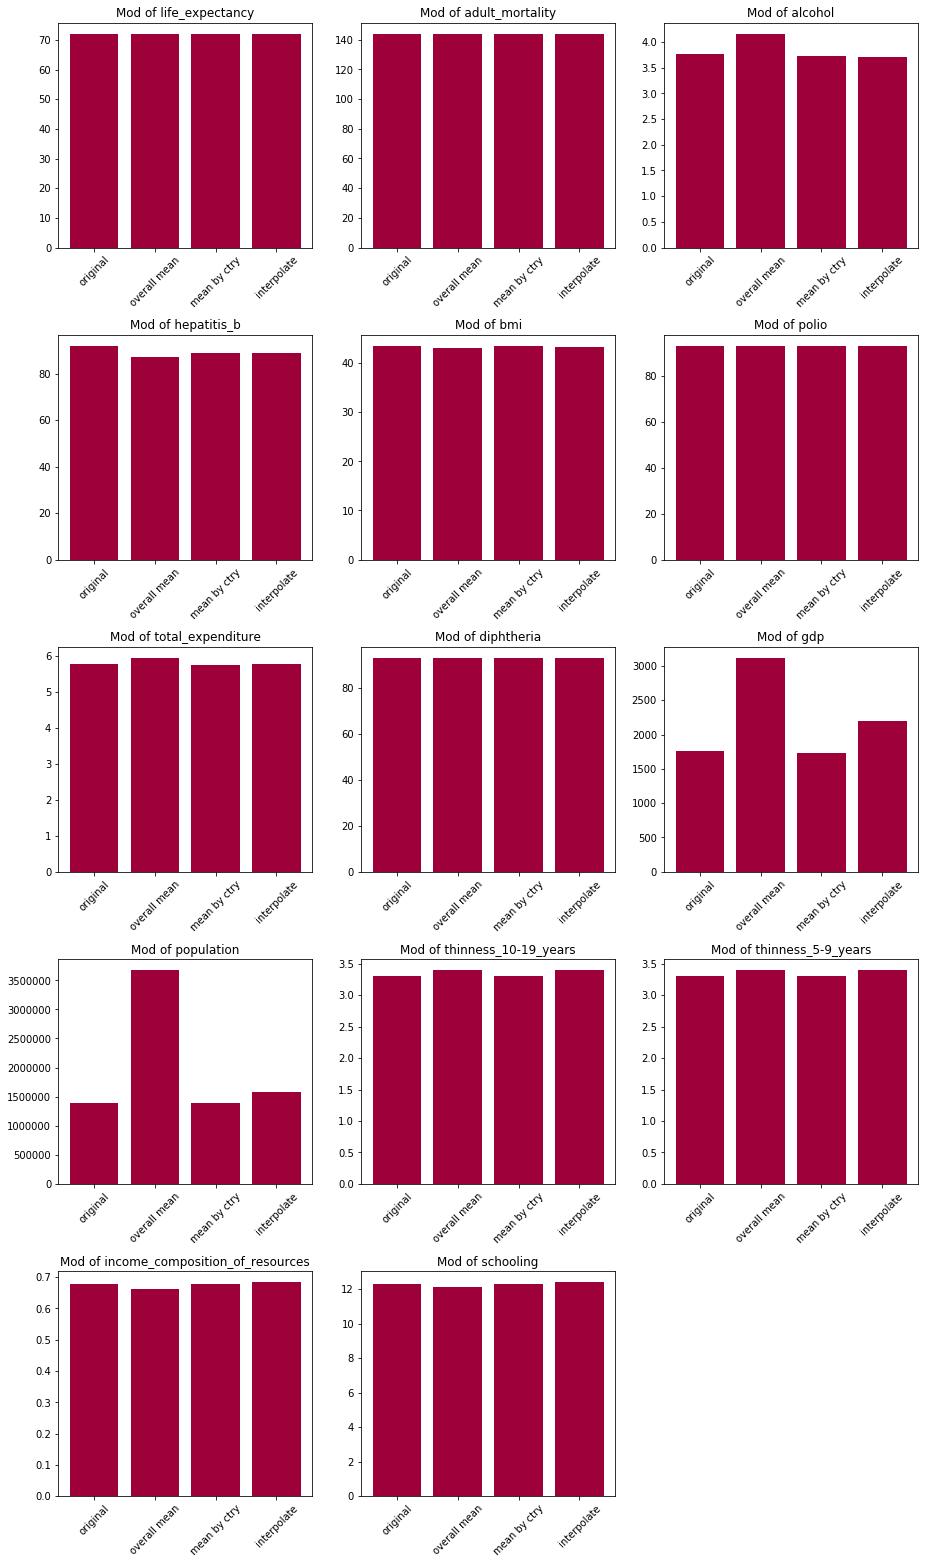

In [8]:
#plotting each method by column
plt.figure(figsize=(13,60))

for i, col in enumerate(na_cols):
    df = pd.concat([le_df[col], le_df2[col], le_df3[col], le_df4[col]], axis=1)

    plt.subplot(len(na_cols), 3, i+1)
    plt.bar(['original', 'overall mean', 'mean by ctry', 'interpolate'],df.median(), color=('xkcd:cranberry') )
    plt.title(f'Mod of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1. Overall mean is really skewing a few of the columns likely due the most developed countries having a large population and GDP
2. Country by country seems to match the original le_df the closest, but that is likely because there are many nulls still left and dropping them would lose a lot of data.
3. While interpolate seems to affect the data slightly in a few columns, it is closest to the original, and it lets us keep all observations

I will proceed with le_df4's interpolation 

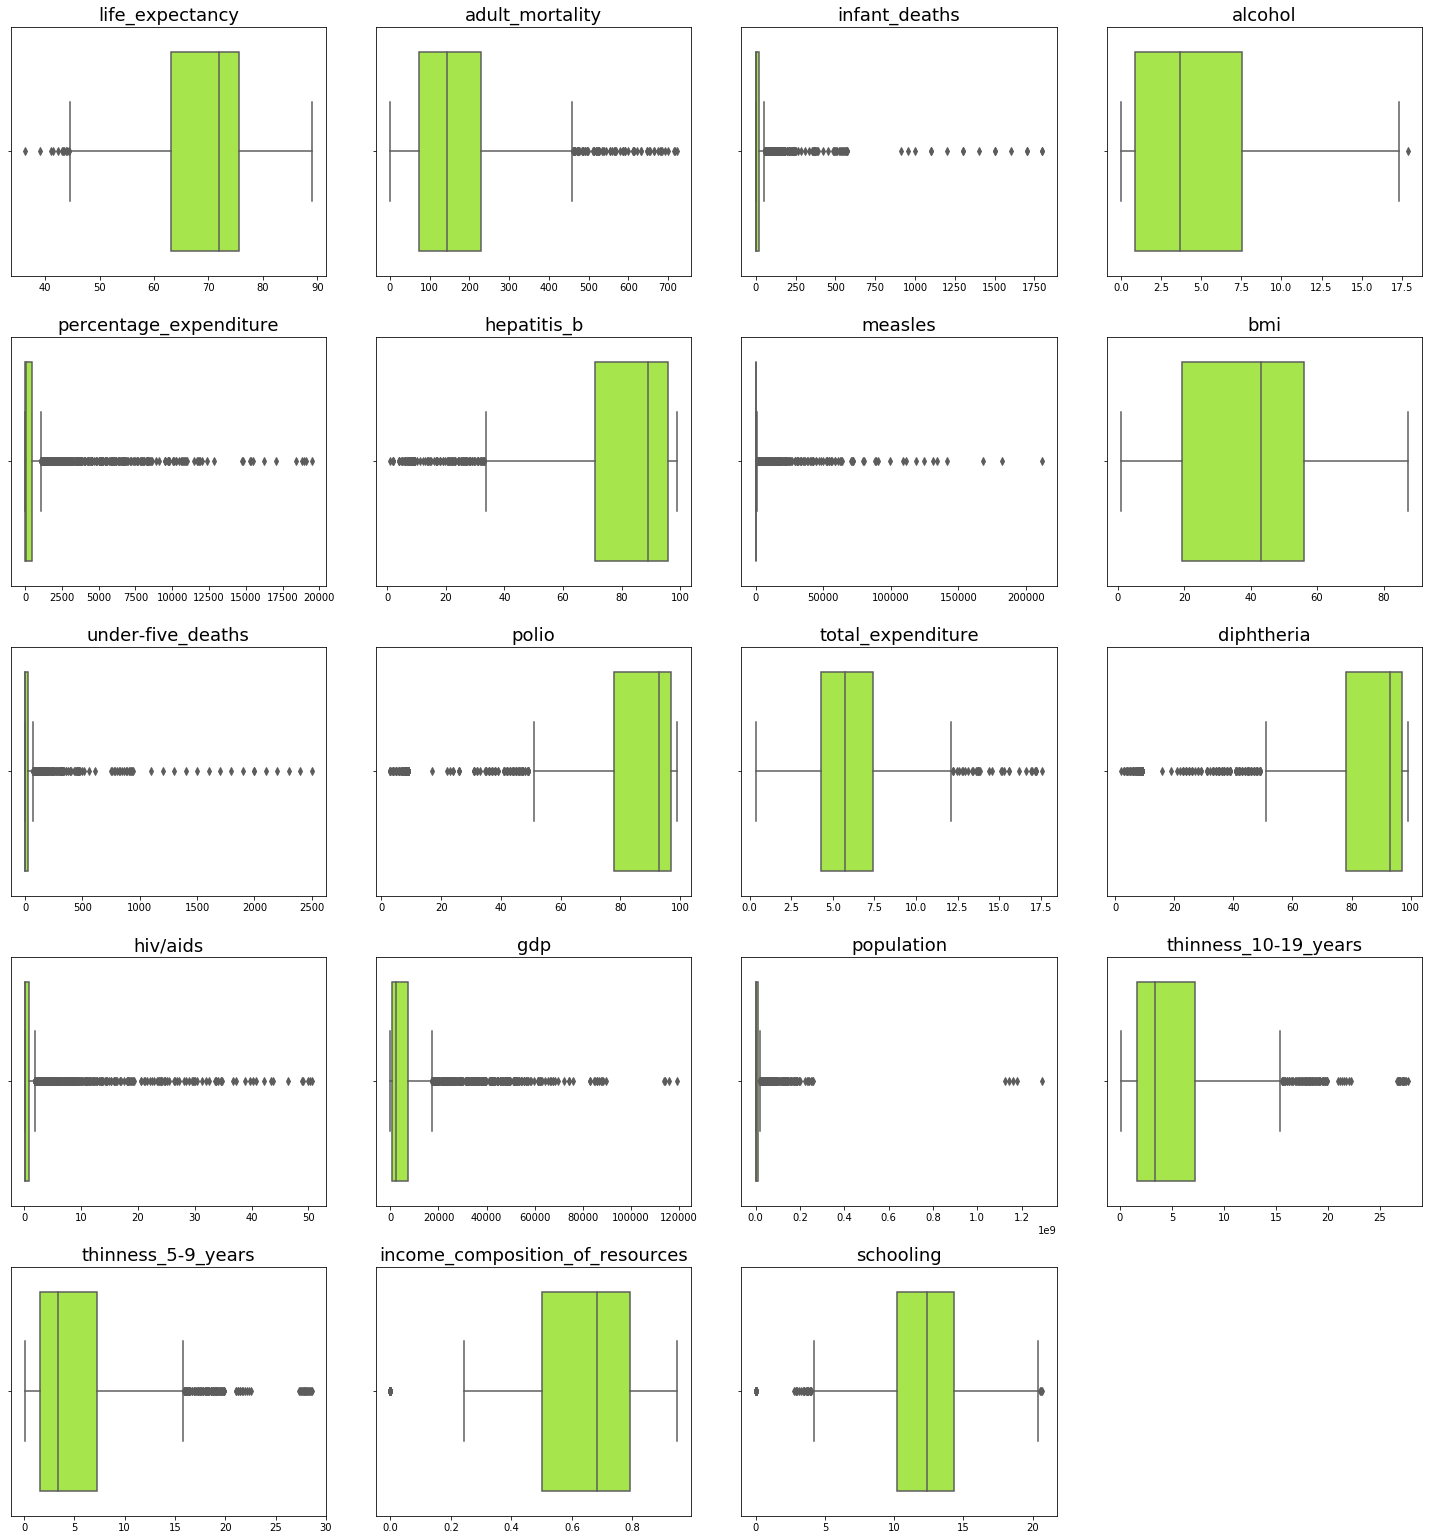

In [9]:
#let's look at the distributions of our continuous variables
num_cols = ['life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_10-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling']

# detecting outliers
plt.figure(figsize=(20,60))

for i, col in enumerate(num_cols):
    plt.subplot(len(na_cols), 4, i+1)
    sns.boxplot(le_df4[col], color=('xkcd:lime'))
    plt.title(f'{col}', fontsize=18)
    plt.xlabel('')

plt.tight_layout()
plt.show()

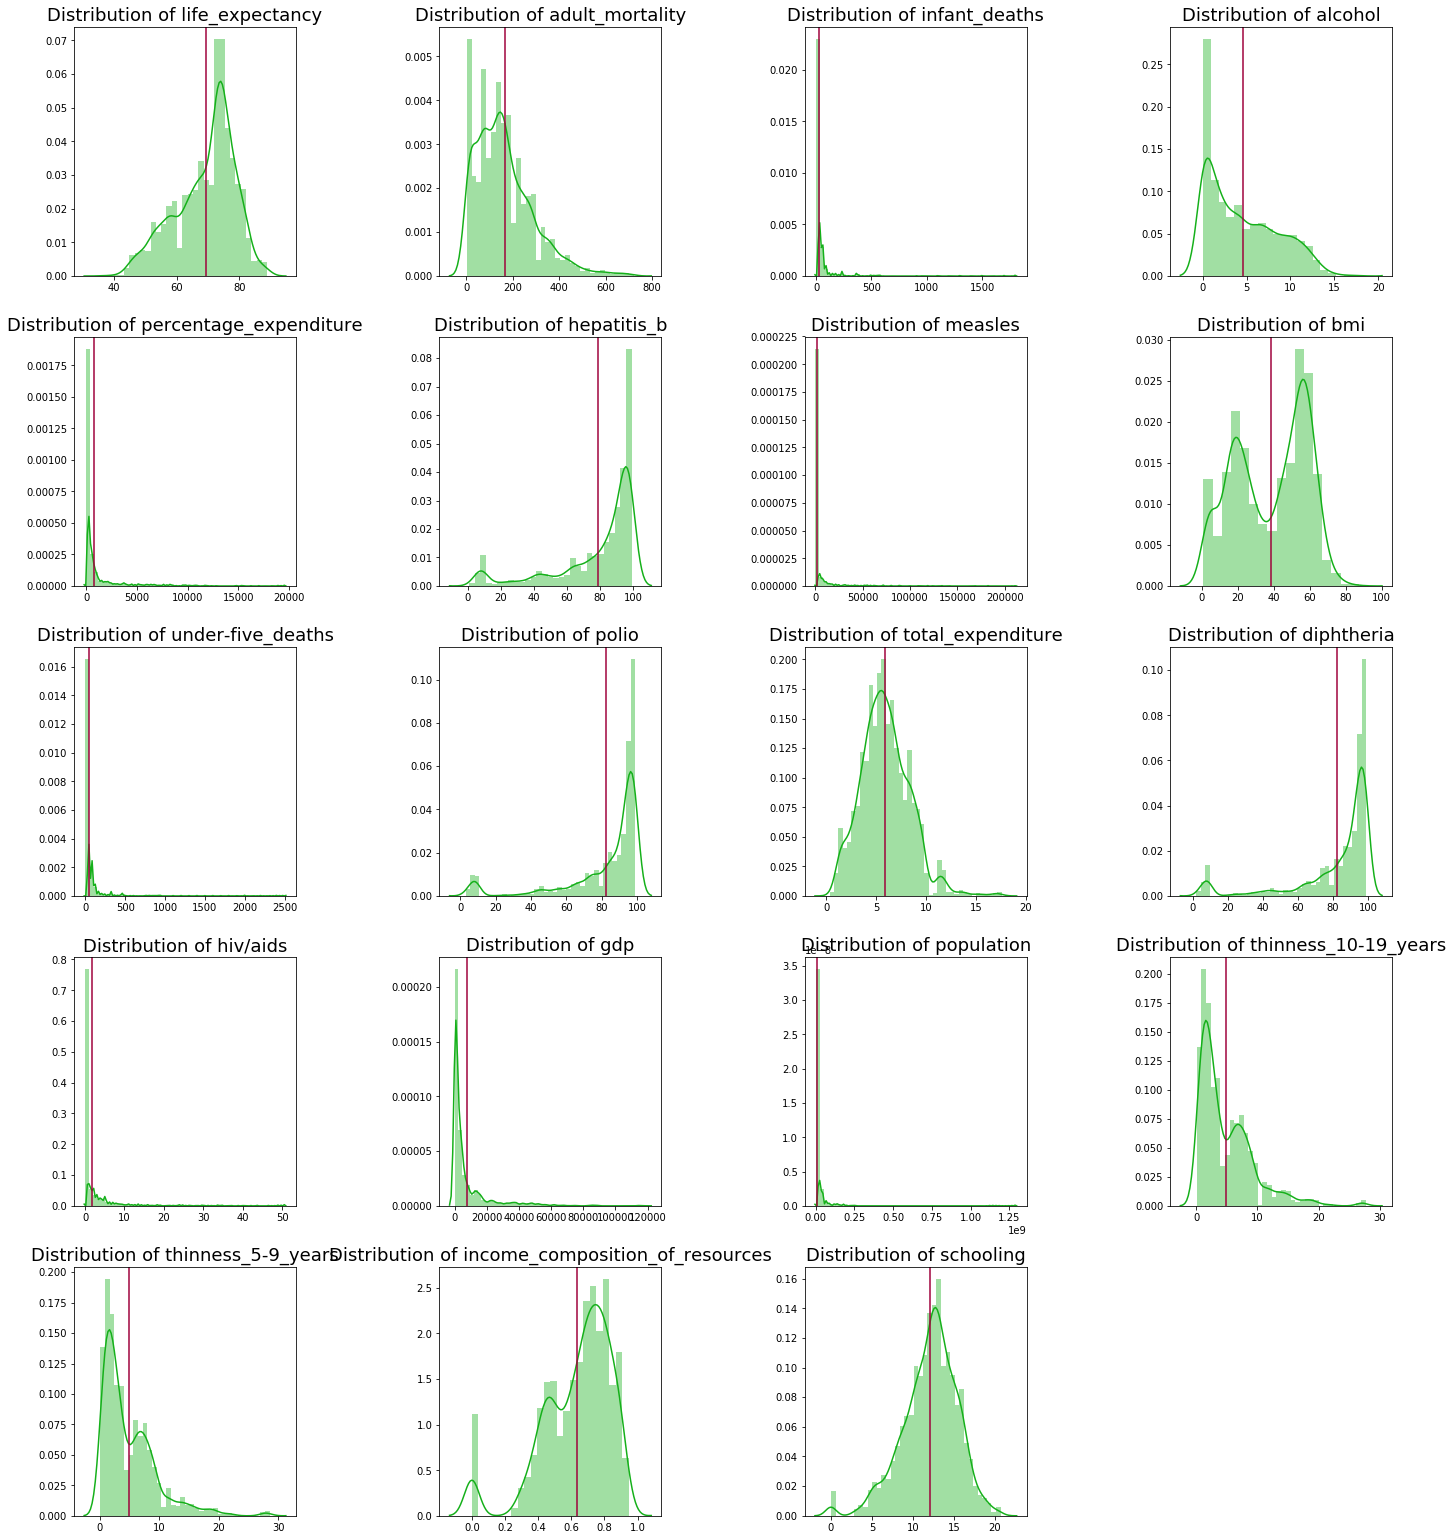

In [10]:
# detecting outliers and distribution via histograms
plt.figure(figsize=(20,60))

for i, col in enumerate(num_cols):
    plt.subplot(len(na_cols), 4, i+1)
    sns.distplot(le_df4[col], color=('xkcd:green'))
    plt.title(f'Distribution of {col}', fontsize=18)
    plt.xlabel('')
    plt.axvline(le_df4.loc[:,col].mean(), color=('xkcd:cranberry')) #red line is the mean

plt.tight_layout()
plt.show()

Here are some issues (of many) I'm seeing:
1. __infant_deaths__ (per 1000 of population) has outliers around 1800. Mathematically unlikely they are having more infant deaths than actual infants. Likely a data collection error. We will drop outliers over 1000.
2. __measles__ (number of reported cases per 1000) has possible outliers at 212k. Same explanation and course of action as above 
3. __under_five_deaths__ (per 1000 of population) has outliers of 2500. Same explantion and course of action as above
4. __percentage_expenditure__ "as a percent of GDP" has outliers around 20k. Unlikely a country is spending 20,000% of their GDP on health, but a large portion of the data is over 300% of GDP, which also seems very high. Because of the range, we will take the log.
5. __population__ and __gdp__ outliers are likely correct as there are few very rich and highly populated countries. Obtaining the log of these values will be helpful and we can winsorize if needed afterwards
6. __bmi__ has a distribution that does not make sense. A bmi over 40 is morbidly obese and somehow some countries recorded a mean of almost 90? That means there is a country (or multiple) with a such a large population of people that are shorter than 5'0" and weigh over 400 lbs. This variable may be dropped entirely.
7. __status__, while a categorical variable, many countries are not categorized correctly as France and Canada (plus about 6 others) are listed as "developing".  

In [11]:
# dropping mistakes in the data collection per the reasoning above
adj_le_df4 = le_df4[(le_df4.infant_deaths<1000) & (le_df4.measles<1000) & (le_df4['under-five_deaths']<1000)]

# winsorizations
adj_le_df4['winz_life_exp'] = winsorize(adj_le_df4['life_expectancy'], (0.10,0.0))
adj_le_df4['winz_tot_exp'] = winsorize(adj_le_df4['total_expenditure'], (0.0,0.10))
adj_le_df4['winz_adult_mort'] = winsorize(adj_le_df4['adult_mortality'], (0.0,0.10))
adj_le_df4['winz_polio'] = winsorize(adj_le_df4['polio'], (0.15,0.0))
adj_le_df4['winz_diph'] = winsorize(adj_le_df4['diphtheria'], (0.10,0.0))
adj_le_df4['winz_hepb'] = winsorize(adj_le_df4['hepatitis_b'], (0.15,0.0))
adj_le_df4['winz_thin_1019_yr'] = winsorize(adj_le_df4['thinness_10-19_years'], (0.0,0.10))
adj_le_df4['winz_thin_59_yr'] = winsorize(adj_le_df4['thinness_5-9_years'], (0.0,0.10))
adj_le_df4['winz_income_comp'] = winsorize(adj_le_df4['income_composition_of_resources'], (0.10,0.0))
adj_le_df4['winz_schooling'] = winsorize(adj_le_df4['schooling'], (0.10,0.05))
adj_le_df4['winz_under5_deaths'] = winsorize(adj_le_df4['under-five_deaths'], (0.0, 0.20))
adj_le_df4['winz_infant_deaths'] = winsorize(adj_le_df4['infant_deaths'], (0.0, 0.15))
adj_le_df4['winz_hiv/aids'] = winsorize(adj_le_df4['hiv/aids'], (0.0, 0.21))
adj_le_df4['winz_measles'] = winsorize(adj_le_df4['measles'], (0.0, 0.17))


# transformations
adj_le_df4['winz_log_gdp'] = winsorize(np.log(adj_le_df4['gdp']), (0.10, 0.0))
adj_le_df4['winz_log_population'] = winsorize(np.log(adj_le_df4['population']), (0.10, 0.0))
adj_le_df4['log_pct_exp'] = np.log(adj_le_df4['percentage_expenditure'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

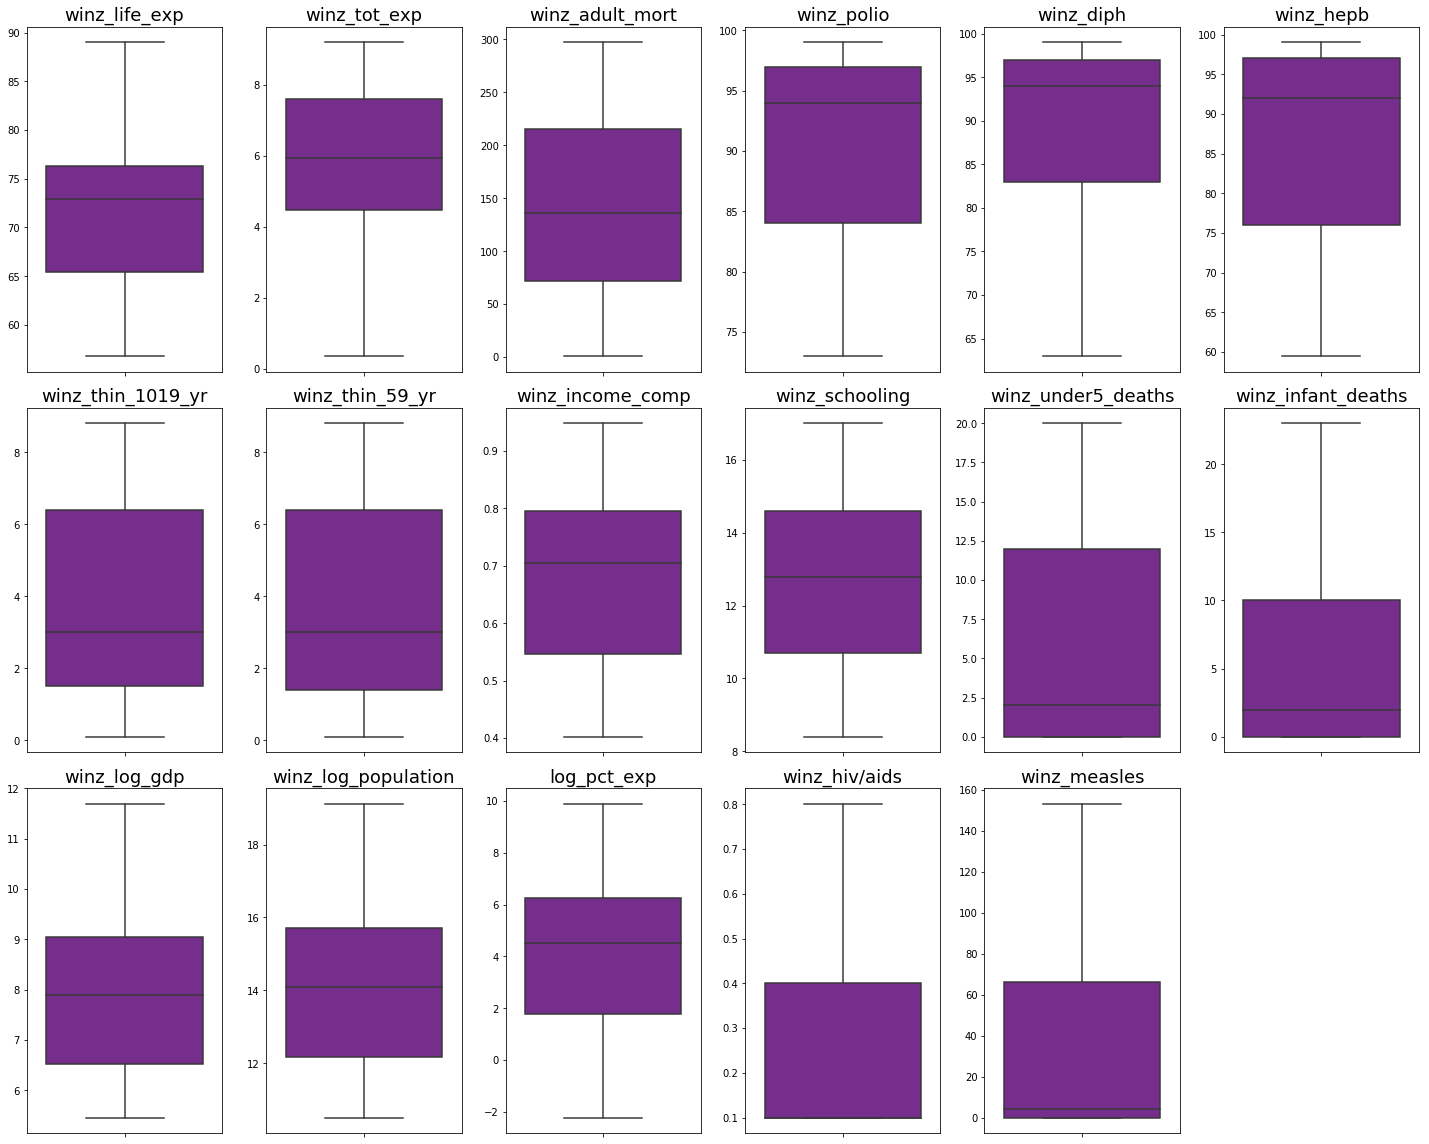

In [12]:
# reinspecting to see how outliers were handled
adj_num_cols = [ 'winz_life_exp', 'winz_tot_exp',
       'winz_adult_mort', 'winz_polio', 'winz_diph', 'winz_hepb',
       'winz_thin_1019_yr', 'winz_thin_59_yr', 'winz_income_comp',
       'winz_schooling', 'winz_under5_deaths', 'winz_infant_deaths',
       'winz_log_gdp', 'winz_log_population', 'log_pct_exp', 'winz_hiv/aids',
       'winz_measles']

plt.figure(figsize=(20,90))

for i, col in enumerate(adj_num_cols):
    plt.subplot(len(adj_num_cols), 6, i+1)
    sns.boxplot(y=adj_le_df4[col], color=('xkcd:purple'))
    plt.title(f'{col}', fontsize=18)
    plt.ylabel('')

plt.tight_layout()
plt.show()
# all outliers have been dealt with

### **Let's explore the data using univariate and multivariate exploration techniques to try to find the relevant variables that may be correlated with life expectancy**

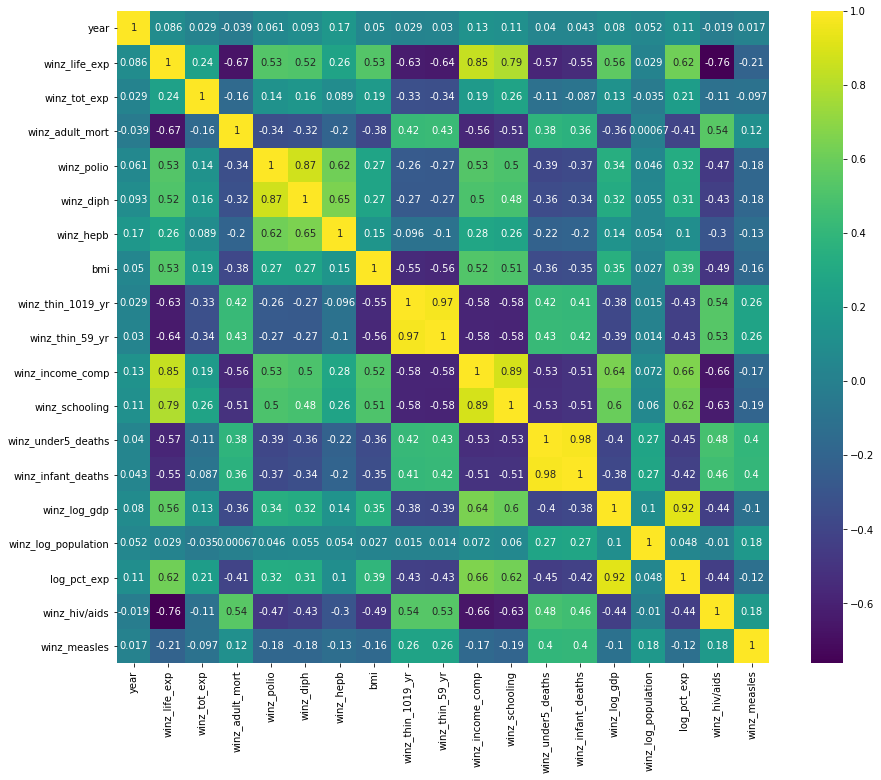

In [13]:
# correlation heat map
adj_corr = adj_le_df4[['year', 'status', 'country', 'winz_life_exp', 'winz_tot_exp',
       'winz_adult_mort', 'winz_polio', 'winz_diph', 'winz_hepb', 'bmi',
       'winz_thin_1019_yr', 'winz_thin_59_yr', 'winz_income_comp',
       'winz_schooling', 'winz_under5_deaths', 'winz_infant_deaths',
       'winz_log_gdp', 'winz_log_population', 'log_pct_exp', 'winz_hiv/aids',
       'winz_measles']].corr()

plt.figure(figsize=(15,12))
sns.heatmap(adj_corr, square=True, annot=True, cmap='viridis');


The highest negative correlations for __winz_life_exp__ are with __winz_hiv/aids__ and __winz_adult_mort__; contrastingly, the highest positive correlations are with __winz_income_comp__ and __winz_schooling__

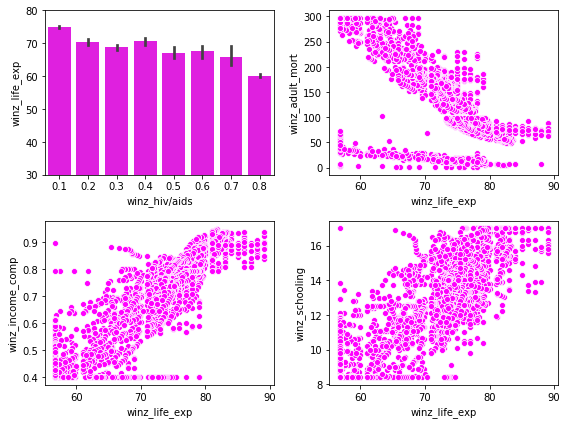

In [14]:
#Let's take a visual of these correlations
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
# Turns out winz_hiv/aids is actually a categorical variable, so I am using a bar plot
ax = sns.barplot(x='winz_hiv/aids', y='winz_life_exp', data=adj_le_df4, color='magenta')
ax.set_ylim(30,80)

plt.subplot(2,2,2)
ax1 = sns.scatterplot(x='winz_life_exp', y='winz_adult_mort', data=adj_le_df4, color='magenta')

plt.subplot(2,2,3)
ax2 = sns.scatterplot(x='winz_life_exp', y='winz_income_comp', data=adj_le_df4, color='magenta')

plt.subplot(2,2,4)
ax3 = sns.scatterplot(x='winz_life_exp', y='winz_schooling', data=adj_le_df4, color='magenta')

plt.tight_layout()
plt.show;

These graphs confirm what we saw with the correlation matrix above:  negative correlations with winz_hiv/aids and winz_adult_mort; ; positive correlations with winz_income_comp and winz_schooling.

It also a little strange seeing the splits in the scatter plots. Likely due to the collection method since multiple data frames were cobbled together.

In [15]:
# Comparing Developed vs Developing
# In order to do this, we will need to correct the incorrectly labeled countries

# List of incorrectly classified countries
incorr_status = ['Canada', 'Chile', 'Greece', 'Finland', 'France', 'Israel', 'Republic of Korea']

# Loop through and change them to Developed
for country in incorr_status:
    adj_le_df4['status'].loc[adj_le_df4.country == country] = 'Developed'

# Verify
print(adj_le_df4[adj_le_df4['status']=='developed']['country'].unique()) 
# Verified;

[]


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



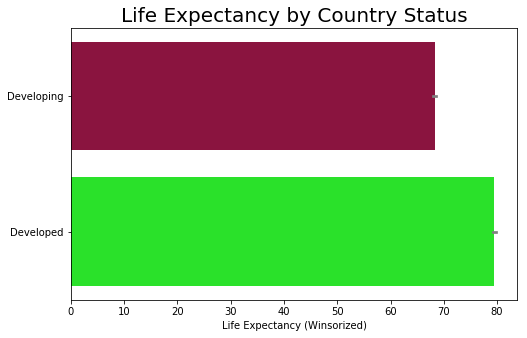

In [16]:
# Plotting Developed v Developing
plt.figure(figsize=(8,5))

sns.barplot(y='status', x='winz_life_exp', data=adj_le_df4, orient='h', 
            palette = ['xkcd:cranberry','xkcd:neon green'], errcolor='grey');
plt.title('Life Expectancy by Country Status', fontsize=20)
plt.xlabel('Life Expectancy (Winsorized)')
plt.ylabel('');

In [17]:
# Differences in life expectancy seem drastic
# Running an independent T Test to see if results are significant
stats.ttest_ind(adj_le_df4[adj_le_df4['status']=='Developed']['winz_life_exp'],
               adj_le_df4[adj_le_df4['status']=='Developing']['winz_life_exp'])

Ttest_indResult(statistic=37.422802138611814, pvalue=4.572473452763448e-242)

The life expectancy of Developed countries is significantly different from Developing countries

### Let's endeavor to feature engineer a couple of basic variables [](http://)



In [18]:
# trying my hand at a sort of sickness ratio and health ratio
adj_le_df4['sickness_index'] = ((adj_le_df4['winz_infant_deaths']+adj_le_df4['winz_measles']+
                                adj_le_df4['winz_under5_deaths']+
                                 adj_le_df4['winz_hiv/aids'])/4)*((adj_le_df4['winz_thin_59_yr']+
                                                                   adj_le_df4['winz_thin_1019_yr'])/2)

adj_le_df4['health_index'] = (adj_le_df4['winz_measles']+adj_le_df4['winz_polio']+
                                 adj_le_df4['winz_diph'])/3

# Creating binary variable for Developed and Developing replacing Status
adj_le_df4 = pd.concat([adj_le_df4, pd.get_dummies(adj_le_df4.status)], axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
# dropping non-transformed columns and low correlation items
adj_le_df4.drop(['status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_10-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling', 'winz_tot_exp',
        'winz_hepb', 'Developing', 'winz_log_population', 'winz_measles',
        'winz_log_gdp', 'year', 'alcohol', 'bmi', 'winz_polio', 'winz_diph'], 
        axis=1, inplace=True)



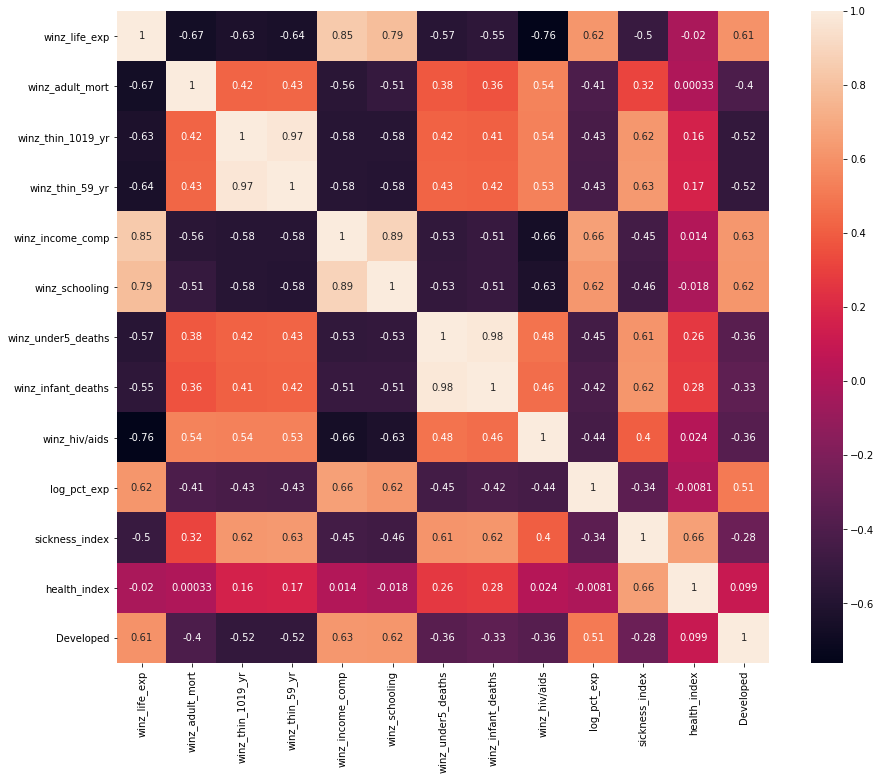

In [20]:
plt.figure(figsize=(15,12))
suite_corr = adj_le_df4.corr()

sns.heatmap(suite_corr, square=True, annot=True);

In [21]:
PCA_df = adj_le_df4[['winz_life_exp', 'winz_adult_mort', 'winz_thin_1019_yr',
       'winz_thin_59_yr', 'winz_income_comp', 'winz_schooling',
       'winz_under5_deaths', 'winz_infant_deaths', 'winz_hiv/aids']]

stndzd_PCA_df = StandardScaler().fit_transform(PCA_df)

sklearn_PCA = PCA(n_components=4)

PCs = sklearn_PCA.fit_transform(stndzd_PCA_df)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA: \n',
    #sklearn_PCA.components_,
    sklearn_PCA.explained_variance_ratio_,
    '\n Eigenvalues of each component: \n',
    sklearn_PCA.explained_variance_
    
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA: 
 [0.63146182 0.13009528 0.09841427 0.06185948] 
 Eigenvalues of each component: 
 [5.68551258 1.17134294 0.88609561 0.55696614]


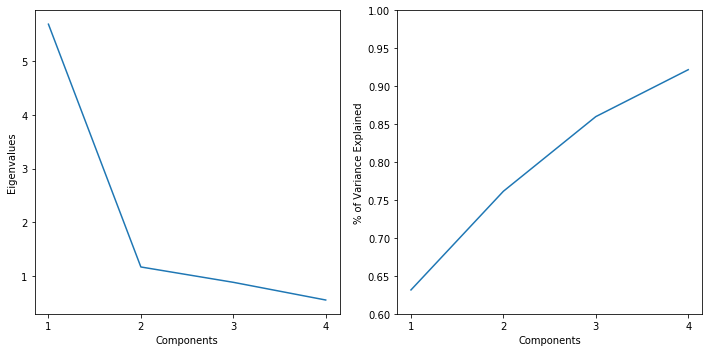

In [22]:
# Let's visualize the above values
fig, ax = plt.subplots(figsize=(10,5))

ax1 = plt.subplot(121)
plt.plot(sklearn_PCA.explained_variance_)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels([1,2,3,4])
ax1.set_xlabel('Components')
ax1.set_ylabel('Eigenvalues')


ax2 = fig.add_subplot(122)
plt.plot(np.cumsum(sklearn_PCA.explained_variance_ratio_))
ax2.set_ylabel('% of Variance Explained')
ax2.set_xlabel('Components')
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels([1,2,3,4])
ax2.set_ylim(.6,1);

plt.tight_layout()

We see here that the top 2 components of the PCA explain 76% of the variance in our data. While respectable, it is not as high of a percentage as some of our other variables.

## **Summarizing Our Findings**

In [23]:
# Bear with me as I create a dictionary of ISO country codes for plotly
ISOs_Country = {
'ABW':'Aruba', 'AFG':'Afghanistan','AGO':'Angola','AIA':'Anguilla','ALA':'Åland Islands','ALB':'Albania',
'AND':'Andorra','ARE':'United Arab Emirates','ARG':'Argentina','ARM':'Armenia','ASM':'American Samoa',
'ATA':'Antarctica','ATF':'French Southern Territories','ATG':'Antigua and Barbuda','AUS':'Australia',
'AUT':'Austria','AZE':'Azerbaijan','BDI':'Burundi','BEL':'Belgium','BEN':'Benin',
'BES':'Bonaire, Sint Eustatius and Saba','BFA':'Burkina Faso','BGD':'Bangladesh','BGR':'Bulgaria',
'BHR':'Bahrain','BHS':'Bahamas','BIH':'Bosnia and Herzegovina','BLM':'Saint Barthélemy','BLR':'Belarus',
'BLZ':'Belize','BMU':'Bermuda','BOL':'Bolivia (Plurinational State of)','BRA':'Brazil','BRB':'Barbados',
'BRN':'Brunei Darussalam','BTN':'Bhutan','BVT':'Bouvet Island','BWA':'Botswana','CAF':'Central African Republic',
'CAN':'Canada','CCK':'Cocos (Keeling) Islands','CHE':'Switzerland','CHL':'Chile','CHN':'China',
'CIV':'Côte d\'Ivoire','CMR':'Cameroon','COD':'Democratic Republic of the Congo','COG':'Congo',
'COK':'Cook Islands','COL':'Colombia','COM':'Comoros','CPV':'Cabo Verde','CRI':'Costa Rica','CUB':'Cuba',
'CUW':'Curaçao','CXR':'Christmas Island','CYM':'Cayman Islands','CYP':'Cyprus','CZE':'Czechia',
'DEU':'Germany','DJI':'Djibouti','DMA':'Dominica','DNK':'Denmark','DOM':'Dominican Republic','DZA':'Algeria',
'ECU':'Ecuador','EGY':'Egypt','ERI':'Eritrea','ESH':'Western Sahara','ESP':'Spain','EST':'Estonia',
'ETH':'Ethiopia','FIN':'Finland','FJI':'Fiji','FLK':'Falkland Islands (Malvinas)','FRA':'France',
'FRO':'Faroe Islands','FSM':'Micronesia (Federated States of)','GAB':'Gabon',
'GBR':'United Kingdom of Great Britain and Northern Ireland','GEO':'Georgia','GGY':'Guernsey','GHA':'Ghana',
'GIB':'Gibraltar','GIN':'Guinea','GLP':'Guadeloupe','GMB':'Gambia','GNB':'Guinea-Bissau',
'GNQ':'Equatorial Guinea','GRC':'Greece','GRD':'Grenada','GRL':'Greenland','GTM':'Guatemala',
'GUF':'French Guiana','GUM':'Guam','GUY':'Guyana','HKG':'Hong Kong','HMD':'Heard Island and McDonald Islands',
'HND':'Honduras','HRV':'Croatia','HTI':'Haiti','HUN':'Hungary','IDN':'Indonesia','IMN':'Isle of Man',
'IND':'India','IOT':'British Indian Ocean Territory','IRL':'Ireland','IRN':'Iran (Islamic Republic of)',
'IRQ':'Iraq','ISL':'Iceland','ISR':'Israel','ITA':'Italy','JAM':'Jamaica','JEY':'Jersey','JOR':'Jordan',
'JPN':'Japan','KAZ':'Kazakhstan','KEN':'Kenya','KGZ':'Kyrgyzstan','KHM':'Cambodia','KIR':'Kiribati',
'KNA':'Saint Kitts and Nevis','KOR':'Republic of Korea','KWT':'Kuwait','LAO':'Lao People\'s Democratic Republic',
'LBN':'Lebanon','LBR':'Liberia','LBY':'Libya','LCA':'Saint Lucia', 'LIE':'Liechtenstein','LKA':'Sri Lanka',
'LSO':'Lesotho','LTU':'Lithuania','LUX':'Luxembourg','LVA':'Latvia','MAC':'Macao',
'MAF':'Saint Martin (French part)','MAR':'Morocco','MCO':'Monaco','MDA':'Republic of Moldova',
'MDG':'Madagascar','MDV':'Maldives','MEX':'Mexico','MHL':'Marshall Islands','MKD':'North Macedonia',
'MLI':'Mali','MLT':'Malta','MMR':'Myanmar','MNE':'Montenegro','MNG':'Mongolia','MNP':'Northern Mariana Islands',
'MOZ':'Mozambique','MRT':'Mauritania','MSR':'Montserrat','MTQ':'Martinique','MUS':'Mauritius','MWI':'Malawi',
'MYS':'Malaysia','MYT':'Mayotte','NAM':'Namibia','NCL':'New Caledonia','NER':'Niger','NFK':'Norfolk Island',
'NGA':'Nigeria','NIC':'Nicaragua','NIU':'Niue','NLD':'Netherlands','NOR':'Norway','NPL':'Nepal','NRU':'Nauru',
'NZL':'New Zealand','OMN':'Oman','PAK':'Pakistan','PAN':'Panama','PCN':'Pitcairn','PER':'Peru','PHL':'Philippines',
'PLW':'Palau','PNG':'Papua New Guinea','POL':'Poland','PRI':'Puerto Rico','PRK':'Democratic People\'s Republic of Korea',
'PRT':'Portugal','PRY':'Paraguay','PSE':'Palestine, State of','PYF':'French Polynesia','QAT':'Qatar','REU':'Réunion',
'ROU':'Romania','RUS':'Russian Federation','RWA':'Rwanda','SAU':'Saudi Arabia','SDN':'Sudan','SEN':'Senegal',
'SGP':'Singapore','SGS':'South Georgia and the South Sandwich Islands','SHN':'Saint Helena, Ascension and Tristan da Cunha',
'SJM':'Svalbard and Jan Mayen','SLB':'Solomon Islands','SLE':'Sierra Leone','SLV':'El Salvador','SMR':'San Marino',
'SOM':'Somalia','SPM':'Saint Pierre and Miquelon','SRB':'Serbia','SSD':'South Sudan','STP':'Sao Tome and Principe',
'SUR':'Suriname','SVK':'Slovakia','SVN':'Slovenia','SWE':'Sweden','SWZ':'Eswatini','SXM':'Sint Maarten (Dutch part)',
'SYC':'Seychelles','SYR':'Syrian Arab Republic','TCA':'Turks and Caicos Islands','TCD':'Chad','TGO':'Togo',
'THA':'Thailand','TJK':'Tajikistan','TKL':'Tokelau','TKM':'Turkmenistan','TLS':'Timor-Leste','TON':'Tonga',
'TTO':'Trinidad and Tobago','TUN':'Tunisia','TUR':'Turkey','TUV':'Tuvalu','TWN':'Taiwan, Province of China',
'TZA':'United Republic of Tanzania','UGA':'Uganda','UKR':'Ukraine','UMI':'United States Minor Outlying Islands',
'URY':'Uruguay','USA':'United States of America','UZB':'Uzbekistan','VAT':'Holy See','VCT':'Saint Vincent and the Grenadines',
'VEN':'Venezuela (Bolivarian Republic of)','VGB':'Virgin Islands (British)','VIR':'Virgin Islands (U.S.)','VNM':'Viet Nam',
'VUT':'Vanuatu','WLF':'Wallis and Futuna','WSM':'Samoa','YEM':'Yemen','ZAF':'South Africa','ZMB':'Zambia',
'ZWE':'Zimbabwe'}

In [24]:
# Turning above dict into df
ISO_df = pd.DataFrame.from_dict(ISOs_Country, orient='index', columns=['country'])

In [25]:
# Grouping WHO df by Country and aggregating the continuous variables we want to plot
reduced_adj_df = adj_le_df4.groupby('country')['winz_life_exp', 'Developed', 
                                               'winz_income_comp', 'winz_schooling'].agg(
    {'winz_life_exp':'mean', 'Developed':'min', 'winz_income_comp':'mean', 'winz_schooling':'mean'}) 


In [26]:
# Merging ISO and WHO dfs together
merged = pd.merge(reduced_adj_df, ISO_df, left_index=True, right_on='country')

In [27]:
# Plotting via the Plotly library
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=4, cols=1,
    row_heights=[0.25, 0.25, 0.25, 0.25],
    vertical_spacing=0.025,
    subplot_titles=("World Life Expectancy", "Status of Countries", 
                    "Income Composition of Resources", "Highest Average Age of Schooling"),
    specs=[[{"type": "Choropleth", "rowspan": 1}],
           [{"type": "Choropleth", "rowspan": 1}],
          [{"type": "Choropleth", "rowspan": 1}],
           [{"type": "Choropleth", "rowspan": 1}]])

fig.add_trace( # Life Expectancy
    go.Choropleth(locations = merged.index,
                  z= merged['winz_life_exp'], 
                  text=merged['country'],
                  name='Life Expectancy',
                  colorbar={'title':'Life<br>Expectancy', 'len':.25, 'x':.99,'y':.896},
                  colorscale='spectral',),
    row=1,col=1
)

fig.add_trace( #Developed v Developing
    go.Choropleth(locations = merged.index,
                  z= merged['Developed'], 
                  text=merged['country'],
                  name='Status of Countries',
                  colorbar={'len':.227, 'x':.99,'y':.629, 'tickmode':'array','nticks':2,
                           'tickvals':[0,1], 'ticktext':('Developing', 'Developed')},
                  colorscale='burgyl_r'),
    row=2,col=1
)

fig.add_trace( # Income Comp
    go.Choropleth(locations = merged.index,
                  z= merged['winz_income_comp'], 
                  text=merged['country'],
                  name='Income Composition of Resources',
                  colorbar={'title':'Index', 'len':.24, 'x':.99,'y':.378},
                  colorscale='bluered',),
    row=3,col=1
)

fig.add_trace( #Schooling
    go.Choropleth(locations = merged.index,
                  z= merged['winz_schooling'], 
                  text=merged['country'],
                  name='Highest Average Age of Schooling',
                  colorbar={'len':.248, 'x':.99,'y':.1275, 'title':'Schooling<br>Age'},
                  colorscale='burgyl_r'),
    row=4,col=1
)

fig.update_layout(
    margin=dict(r=1, t=30, b=10, l=30),
    width=700,
    height=1400,
)

fig.show()

From the graphs above, we can see geographic correlations regarding the differences in Life Expectancy, Developing or Developed nations, Income Composition of Resources, and Highest Average Age of Schooling. It further supports our earlier findings that Developed nations on average have a higher life expectancy than those in Developing nations, and it shows that Income Composition of Resources and Highest Average Age of Schooling are also correlated to Life Expectancy.

While there were many issues with the data due to how it was collected (Most notably the outliers at the beginning and the fact China, India, and multiple countries near the Indian Ocean were excluded due to a lack of data or incorrectly collected data) , there were still valuable insights from this data set. 